In [1]:
from torchvision import models

In [12]:
# Capitalized names in the listing of torchvision models shows a number of popular models
MODEL_NAMES = list(filter(lambda m: m[0].isupper(), dir(models)))

In [13]:
INSTANTIATION_FUNCTIONS = list(filter(lambda m: m[0].islower(), dir(models)))

# AlexNet
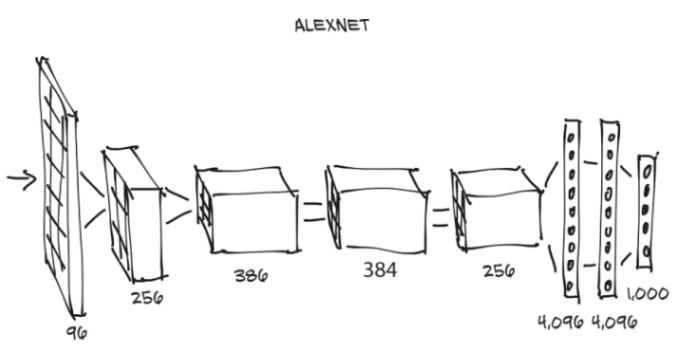

In [19]:
alexnet = models.AlexNet()

alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [28]:
# instantiate a resnet model with pre-trained weights
weights = models.ResNet101_Weights.DEFAULT
resnet101 = models.resnet101(weights=weights)

# using pretrained=true is now deprecated, use weights=ResNet101_Weights.DEFAULT

What we are seeing above is modules, one per line. Note that they have nothing in common with Python modules: they are individual operations, the building blocks of a neural network. They are also called layers in other deep learning frameworks.

If we scroll down, we’ll see a lot of Bottleneck modules repeating one after the other (101 of them!), containing convolutions and other modules. That’s the anatomy of a typical deep neural network for computer vision: a more or less sequential cascade of filters and nonlinear functions, ending with a layer (fc) producing scores for each of the 1,000 output classes (out_features).

In [29]:
from torchvision import transforms

# preprocess function that will scale the input image to 256 × 256, crop the image to 224 × 224 around the center, transform it to a 
# tensor (a PyTorch multidimensional array: in this case, a 3D array with color, height, and width), and normalize its RGB (red, green, blue) components 
# so that they have defined means and standard deviations.
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406 ],
        std=[0.229, 0.224, 0.225 ]
    )])

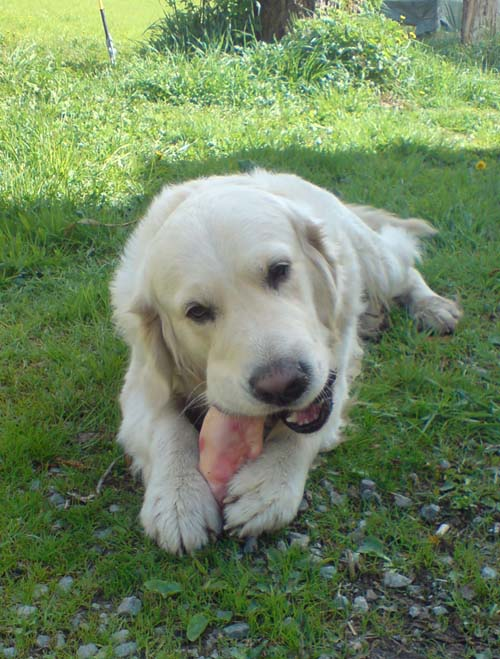

In [64]:
import urllib.request
from PIL import Image
urllib.request.urlretrieve("https://upload.wikimedia.org/wikipedia/commons/a/af/Golden_retriever_eating_pigs_foot.jpg", "data/lab.jpg")
img = Image.open("data/lab.jpg")
img

In [31]:
# preprocess the image
img_t = preprocess(img)

In [32]:
import torch
batch_t = torch.unsqueeze(img_t, 0)

In [33]:
# Put the trained model in inference mode
resnet101.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [38]:
out = resnet101(batch_t)
v, index = torch.max(out, 1)
v, index

(tensor([8.2586], grad_fn=<MaxBackward0>), tensor([207]))

In [35]:
prediction = out.squeeze(0).softmax(0)
class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = weights.meta["categories"][class_id]
print(f"{category_name}: {100 * score:.1f}%")

golden retriever: 74.8%


In [43]:
_, indices = torch.sort(prediction, descending=True)
[ (weights.meta["categories"][idx], f'{100 * prediction[idx].item():.1f}%') for idx in indices[:5]]

[('golden retriever', '74.8%'),
 ('Labrador retriever', '2.9%'),
 ('kuvasz', '1.5%'),
 ('curly-coated retriever', '0.2%'),
 ('Sussex spaniel', '0.2%')]


##CycleGAN

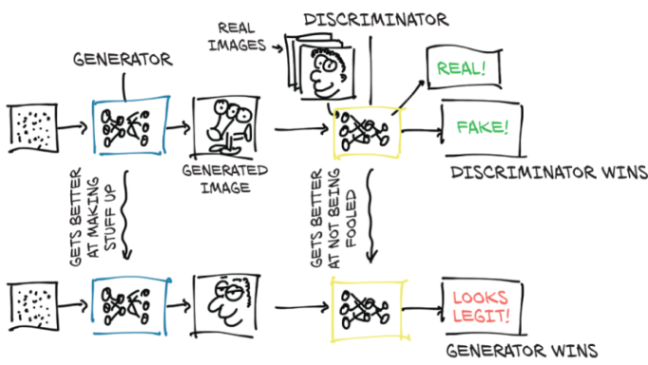


##CycleGAN trainined to fool both discriminator networks


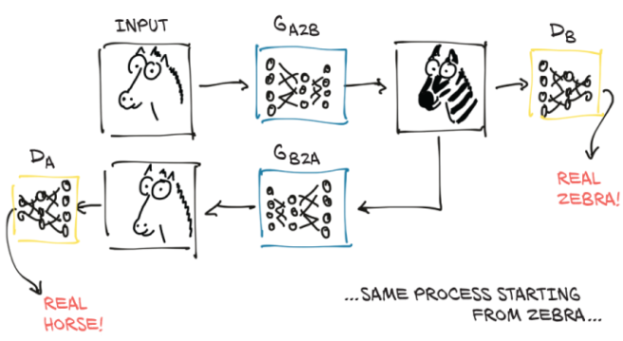


In [44]:
import torch
import torch.nn as nn

class ResNetBlock(nn.Module): # <1>

    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    def build_conv_block(self, dim):
        conv_block = []

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim),
                       nn.ReLU(True)]

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x) # <2>
        return out


class ResNetGenerator(nn.Module):

    def __init__(self, input_nc=3, output_nc=3, ngf=64, n_blocks=9): # <3> 

        assert(n_blocks >= 0)
        super(ResNetGenerator, self).__init__()

        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
                 nn.InstanceNorm2d(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1, bias=True),
                      nn.InstanceNorm2d(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResNetBlock(ngf * mult)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=True),
                      nn.InstanceNorm2d(int(ngf * mult / 2)),
                      nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input): # <3>
        return self.model(input)


In [45]:
netG = ResNetGenerator()
netG

ResNetGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResNetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
     

In [49]:
model_path = './data/horse2zebra_0.4.0.pth'
model_data = torch.load(model_path)
netG.load_state_dict(model_data)

<All keys matched successfully>

In [50]:
# Put NetG in eval mode
netG.eval()

ResNetGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResNetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
     

In [52]:
from PIL import Image
from torchvision import transforms
preprocess = transforms.Compose([transforms.Resize(256),
                                transforms.ToTensor()])


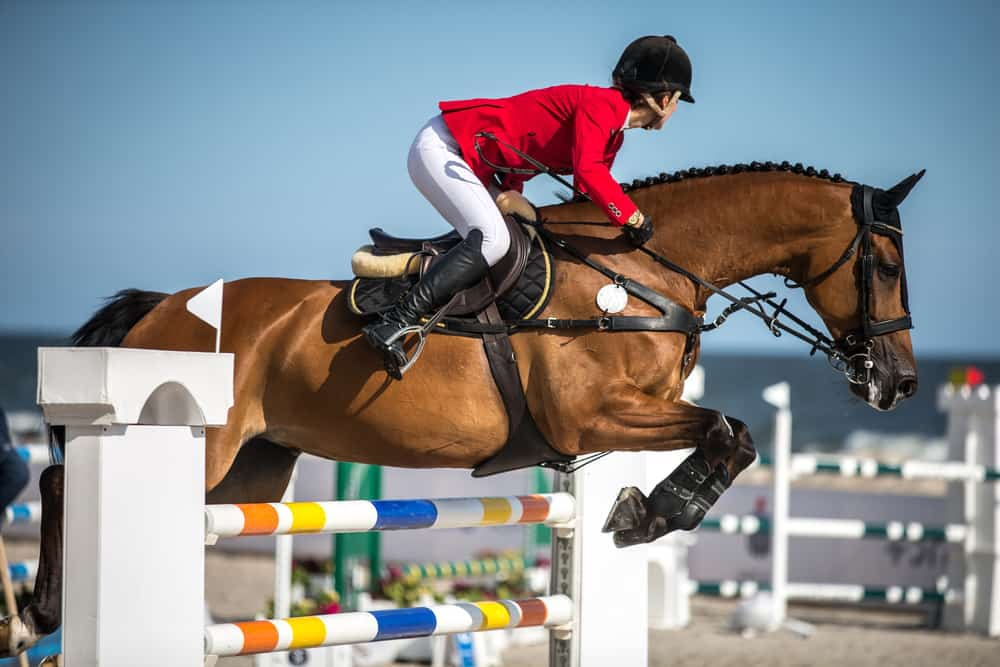

In [63]:
img = Image.open("./data/horse.jpg")
img

In [61]:

img_t = preprocess(img)
batch_t = torch.unsqueeze(img_t, 0)
batch_out = netG(batch_t)

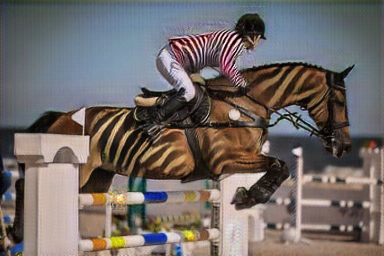

In [62]:

out_t = (batch_out.data.squeeze() + 1.0) / 2.0
out_img = transforms.ToPILImage()(out_t)
out_img.save('./data/zebra.jpg')
out_img


## A pretrained network that describes scenes
### Andrej Karpathy and Li Fei-Fei, “Deep Visual-Semantic Alignments for Generating Image Descriptions,” 
* https://cs.stanford.edu/people/karpathy/cvpr2015.pdf

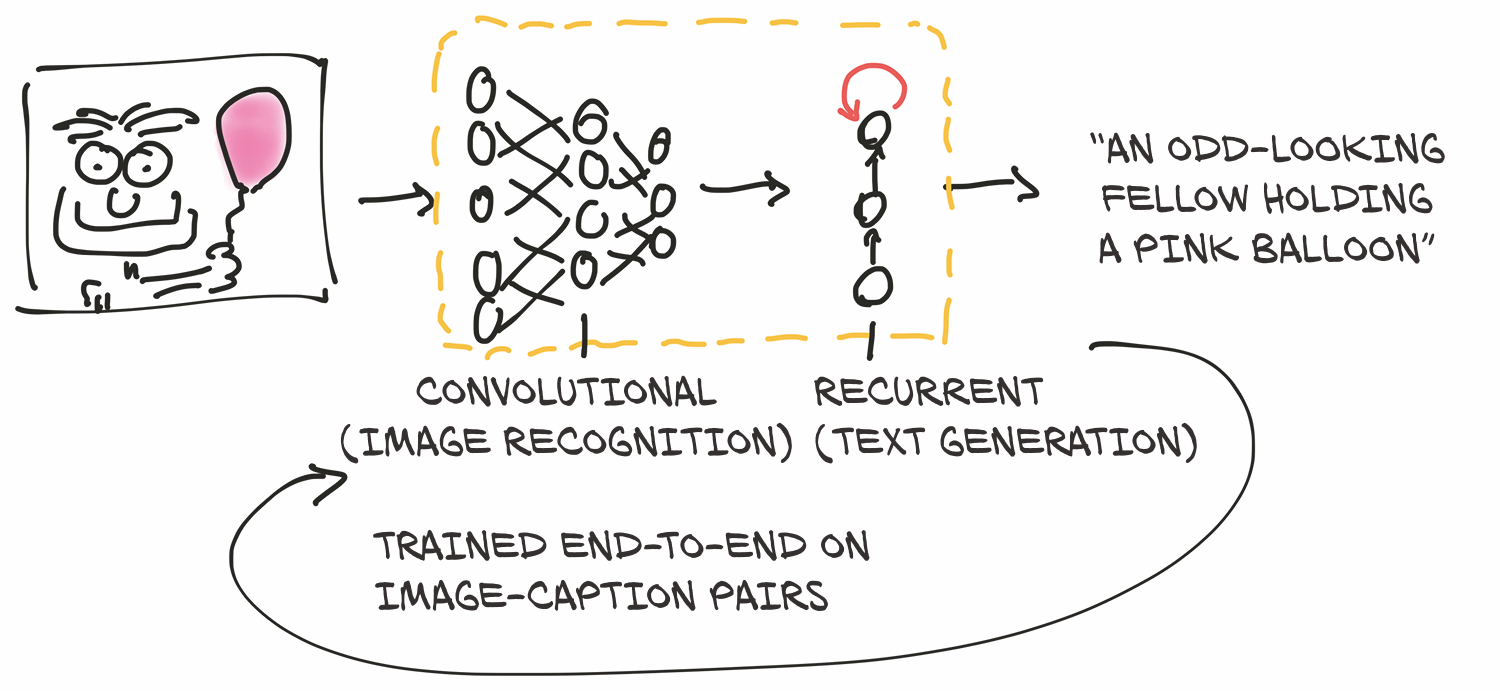


# Setting up a clone of ImageCaptioning PyTorch
python -m pip install -e .

pip install git+https://github.com/ruotianluo/meshed-memory-transformer.git

pip install h5py

pip install lmdbdict

pip install -U scikit-image

After installing all dependent libaries, the eval script fails with missing `infos.pkl` file